We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# Overview

We illustrate the numerical implementation and the use of the Mz-criterion on 2-D homogeneous, isotropic turbulence. The LCS diagnostic is applied to the two-dimensional turbulence simulation. The notebook is structured as follows:

1. Import velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
2. Define computational parameters and data.
3. Define spatio-temporal domain.
4. Interpolate velocity from (discrete) gridded data.
5. $ \mathrm{Mz-criterion} $:

    Compute the strain acceleration tensor $ \mathbf{M}(\mathbf{x}, t) $ along every trajectory launched at $ \mathbf{x}_0 $ over the time-interval $ t \in [t_0, t_N] $.
    
    \begin{equation}
        \mathbf{M}(\mathbf{x}, t) = \dfrac{D\mathbf{S}(\mathbf{x}, t)}{Dt} + \mathbf{S}(\mathbf{x}, t)\mathbf{\nabla v}(\mathbf{x}, t)+(\mathbf{\nabla v}(\mathbf{x}, t))^T\mathbf{S}(\mathbf{x}, t)
        \label{eq: M} \tag{1}
    \end{equation}
    
    The criterion uses a frame-independent Eulerian partition of the physical space that is based on the sign definiteness of the strain acceleration tensor $ \mathbf{M} $ over directions of zero strain.
    
    Take the inner product between a material vector $ \mathbf{\xi} $ and $ \mathbf{S}\mathbf{\xi} $
    
    \begin{equation}
        \mathbf{C}(\mathbf{\xi};\mathbf{x},t) = \langle \mathbf{\xi}, \mathbf{S}(\mathbf{\mathbf{x},t}) \mathbf{\xi} \rangle
        \label{eq: C} \tag{2}
    \end{equation} and define the zero-strain set as
    
    \begin{equation}
    Z(\mathbf{x},t) = \lbrace \mathbf{\xi} \in \mathbb{R}^2: \langle \mathbf{\xi}, \mathbf{S}\mathbf{\xi} \rangle = 0 \rbrace
    \label{eq: Z} \tag{3}
    \end{equation}
    
    ![alt text](LinearizedFlowGeometry.png "Linearized flow geometry")
    
    Hence, $ Z $ is spanned by the vectors:
    
    \begin{equation}
        \xi^+ = \begin{pmatrix} s_{22} \\ -s_{12} + \dfrac{|S_{norm}|}{\sqrt{2}} \end{pmatrix} \label{eq: xi^+} \tag{4}
    \end{equation}
    
    \begin{equation}
        \xi^- = \begin{pmatrix} s_{22} \\ -s_{12} - \dfrac{|S_{norm}|}{\sqrt{2}} \end{pmatrix} \label{eq: xi_minus} \tag{5}
    \end{equation}
    
    If the trajectory $ \mathbf{x}(t) $ at time $ t $ satisfies $ \mathbf{M}_Z(\mathbf{x}, t) \succ 0 $, then it is in a hyperbolic flow region. 
    If $ \mathbf{M}_Z(\mathbf{x}, t) $ is indefinite, then it is in an elliptic flow region. 
    If $ \mathbf{M}_Z(\mathbf{x}, t) $ is positive semi-definite, then it is in a parabolic flow region. $ \mathbf{M}_Z $ denotes the restriction of $ M $ onto the generalized zero-strain cone $ Z $. 
    
    Define
    \begin{equation}
        \phi^{\pm} = \dfrac{1}{2} \dfrac{\langle \mathbf{\xi}^{\pm}, \mathbf{M} \mathbf{\xi}^{\pm} \rangle}{|\mathbf{\xi}^{\pm}||\mathbf{S}\mathbf{\xi}^{\pm}|}
        \tag{6}
    \end{equation} as the normalized instantaneous net flux through the appropriate component of the zero strain set. Either $ \phi^{+} $ or $ \phi^{-} $ must be non-negative. Further define $ \phi^0 = min(\phi^+, \phi^-) $. $ \phi_0 $ is positive in hyperbolic regions and negative in elliptic regions. Based on $ \phi_0 $ we compute the time a trajectory spends in hyperbolic or elliptic flow regions. Note that if $ \mathbf{S} = 0 $, then the trajectory is in an elliptic flow region.
    Compute the total time spent in a hyperbolic flow region $ \tau_H $ of the trajectory $ \mathbf{x}(t) $ launched from $ \mathbf{x}_0 $ over the time-interval $ [t_0, t_N] $.
    
    Compute the total time spent in an elliptic flow region $ \tau_E $ of the trajectory $ \mathbf{x}(t) $ launched from $ \mathbf{x}_0 $ over the time-interval $ [t_0, t_N] $.
    
    Plot $ \tau_H $ and $ \tau_E $ with respect to the initial position of the particles.  
6. References

# Import data

In [2]:
# import scipy
import scipy.io

# import numpy
import numpy as np

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'

# import progress bar
from tqdm.notebook import tqdm

# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in tqdm(sorted(os.listdir(turb_u)), total = 251):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1
        
# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

  0%|          | 0/251 [00:00<?, ?it/s]

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 8

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 20 # float

# Time step-size
dt = 0.05 # float

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# resolution
Nx = 300
Ny = 300

# set x-limits
xmin = 0
xmax = 4

# set x-limits
ymin = 0
ymax = 4

# specify domain over which to compute LCS
x_domain = np.linspace(xmin, xmax, Nx)
y_domain = np.linspace(ymin, ymax, Ny)

# make sure that domain is part of the data domain.
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " tN must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# grid-spacing
dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

  0%|          | 0/251 [00:00<?, ?it/s]

# Hyperbolicity/Ellipticity time $ \tau_{\mathcal{H}}, \tau_{\mathcal{E}} $

Next, we compute the time spent in hyperbolic and elliptic flow regions by particles launched from $ \mathbf{x}_0 $ at time $ t_0 $.

In [6]:
# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import function to compute eigenvalues
from ipynb.fs.defs.eigen import eigen

# import math tools
from math import sqrt

# Import package for parallel computing
from joblib import Parallel, delayed

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

# Compute hyperbolicity, parabolicity and ellipticity time
def tau_(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])  # array (2, Nx*Ny)
    
    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data, verbose = True)[0] # shape (Nt, 2, Nx*Ny)
    
    
    # Initialize matrices which store the information of whether the particle is in a hyperbolic/parabolic/elliptic flow region
    Hyperbolicity = np.zeros((Fmap.shape[0], Fmap.shape[-1]))
    Parabolicity = np.zeros((Fmap.shape[0], Fmap.shape[-1]))
    Ellipticity = np.zeros((Fmap.shape[0], Fmap.shape[-1]))
    
    # compute strain acceleration tensor along trajectories and check if trajectory is in hyperbolic or elliptic flow region.
    for i in range(Fmap.shape[0]-1):
        
        if np.around(i/(Fmap.shape[0]-1)*100, 2) % 2 == 0:
            
            print("Percentage completed: ", np.around(i/(Fmap.shape[0]-1)*100, 2))
          
        # Compute gradient of velocity field
        grad_vel = gradient_velocity(time[i], Fmap[i,:,:], X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
        
        # Compute rate of strain tensor
        S = .5*(grad_vel+grad_vel.transpose(1,0,2))
        
        # Compute gradient of velocity field at t+dt in order to evaluate partial derivative of S with respect to t
        grad_vel_dt = gradient_velocity(time[i+1], Fmap[i+1,:,:], X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
        
        # Compute rate of strain tensor at t + dt
        S_dt = .5*(grad_vel_dt+grad_vel_dt.transpose(1,0,2))
        
        for ii in range(Fmap.shape[-1]):
            
    
        
            # Compute M-tensor
            M = (S_dt[:,:,ii]-S[:,:,ii])/(time[i+1]-time[i])+S[:,:,ii]@grad_vel[:,:,ii]+grad_vel[:,:,ii].transpose()@S[:,:,ii]
            
            # Compute norm of S
            S_norm = np.linalg.norm(S[:,:,ii].ravel(), ord = 2)
            
            # Compute vectors specifying boundary between sectors psi_minus and psi_plus
            xi_minus = np.array([S[1,1,ii], -S[0,1,ii]-S_norm/sqrt(2)])
            xi_plus = np.array([S[1,1,ii], -S[0,1,ii]+S_norm/sqrt(2)])
            
            # phi_minus
            phi_minus = 1/2*(xi_minus.transpose()@(M@xi_minus))/(np.linalg.norm(xi_minus, ord = 2)*np.linalg.norm(S[:,:,ii]@xi_minus, ord = 2))
            # phi_plus
            phi_plus = 1/2*(xi_plus.transpose()@(M@xi_plus))/(np.linalg.norm(xi_plus, ord = 2)*np.linalg.norm(S[:,:,ii]@xi_plus, ord = 2))
            
            phi0 = min(phi_minus, phi_plus)
            
            # check if Mz is positive definite
            if phi0 > 0:
                Hyperbolicity[i,ii] = 1
            
            # check if Mz is indefinite
            elif phi0 < 0 or np.sum(np.abs(S[:,:,ii])) == 0:
                Ellipticity[i,ii] = 1
                
            else:
                Parabolicity[i,ii] = 1
    
    tau_Hyperbolicity = np.sum(Hyperbolicity, axis = 0)*dt
    tau_Parabolicity = np.sum(Parabolicity, axis = 0)*dt
    tau_Ellipticity = np.sum(Ellipticity, axis = 0)*dt
    
    return tau_Hyperbolicity, tau_Parabolicity, tau_Ellipticity

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

# compute Mz criterion
results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(tau_)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract Hyperbolicity and Ellipticity times from results of parallel computing
tau_Hyperbolicity = results[0][0]
tau_Parabolicity = results[0][1]
tau_Ellipticity = results[0][2]

for res in results[1:]:
    tau_Hyperbolicity = np.append(tau_Hyperbolicity, res[0], axis = -1)
    tau_Parabolicity = np.append(tau_Parabolicity, res[1], axis = -1)
    tau_Ellipticity = np.append(tau_Ellipticity, res[2], axis = -1)
    
# Reshape array from vectorized form to structured meshgrid
tau_Hyperbolicity = tau_Hyperbolicity.reshape((X_domain.shape[0], X_domain.shape[1])) # array (2, 2, Ny, Nx)
tau_Parabolicity = tau_Parabolicity.reshape((X_domain.shape[0], X_domain.shape[1])) # array (2, 2, Ny, Nx)
tau_Ellipticity = tau_Ellipticity.reshape((X_domain.shape[0], X_domain.shape[1])) # array (2, 2, Ny, Nx)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 35.1min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 35.3min remaining: 105.8min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 35.3min remaining: 58.9min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 35.5min remaining: 35.5min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 35.9min remaining: 21.5min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 36.2min remaining: 12.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 36.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 36.5min finished


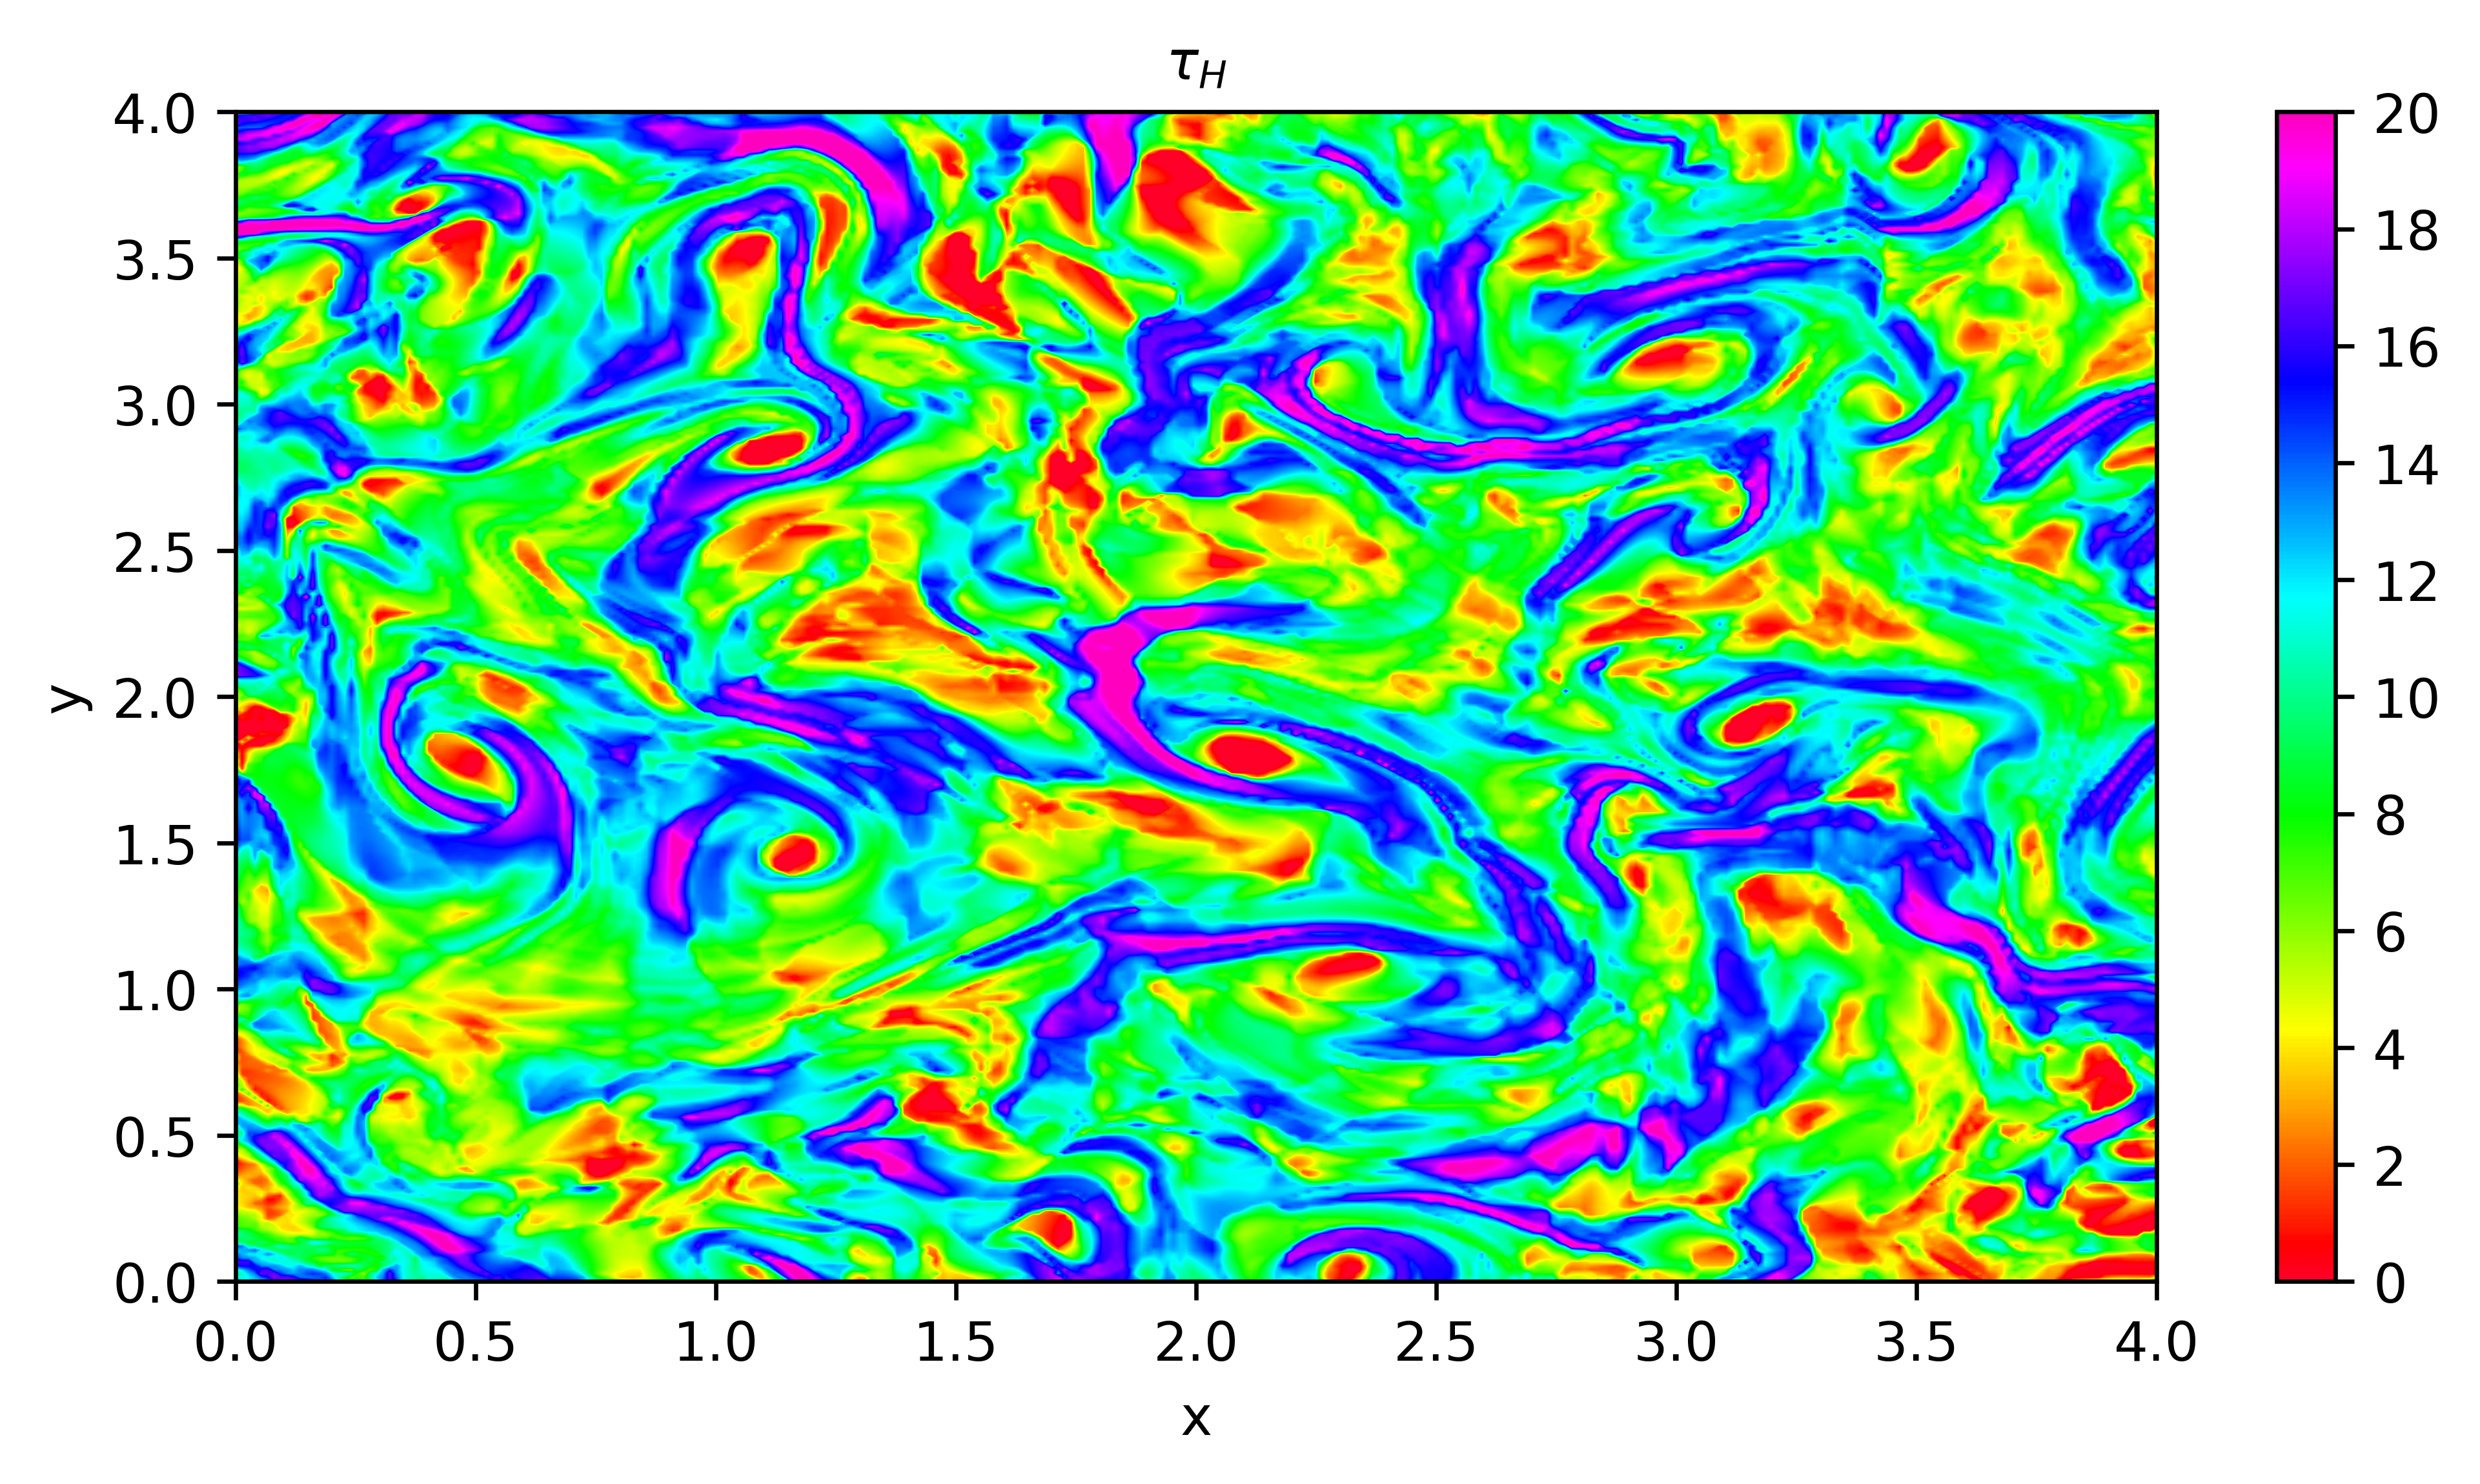

In [8]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of hyperbolicity time over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(tau_Hyperbolicity), cmap = "gist_rainbow", levels = 600)

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 0.5))
ax.set_yticks(np.arange(ymin, ymax+0.1, 0.5))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, 20+.1, 2))

# Title
ax.set_title(r'$ \tau_H $', fontsize = 10)

plt.show()

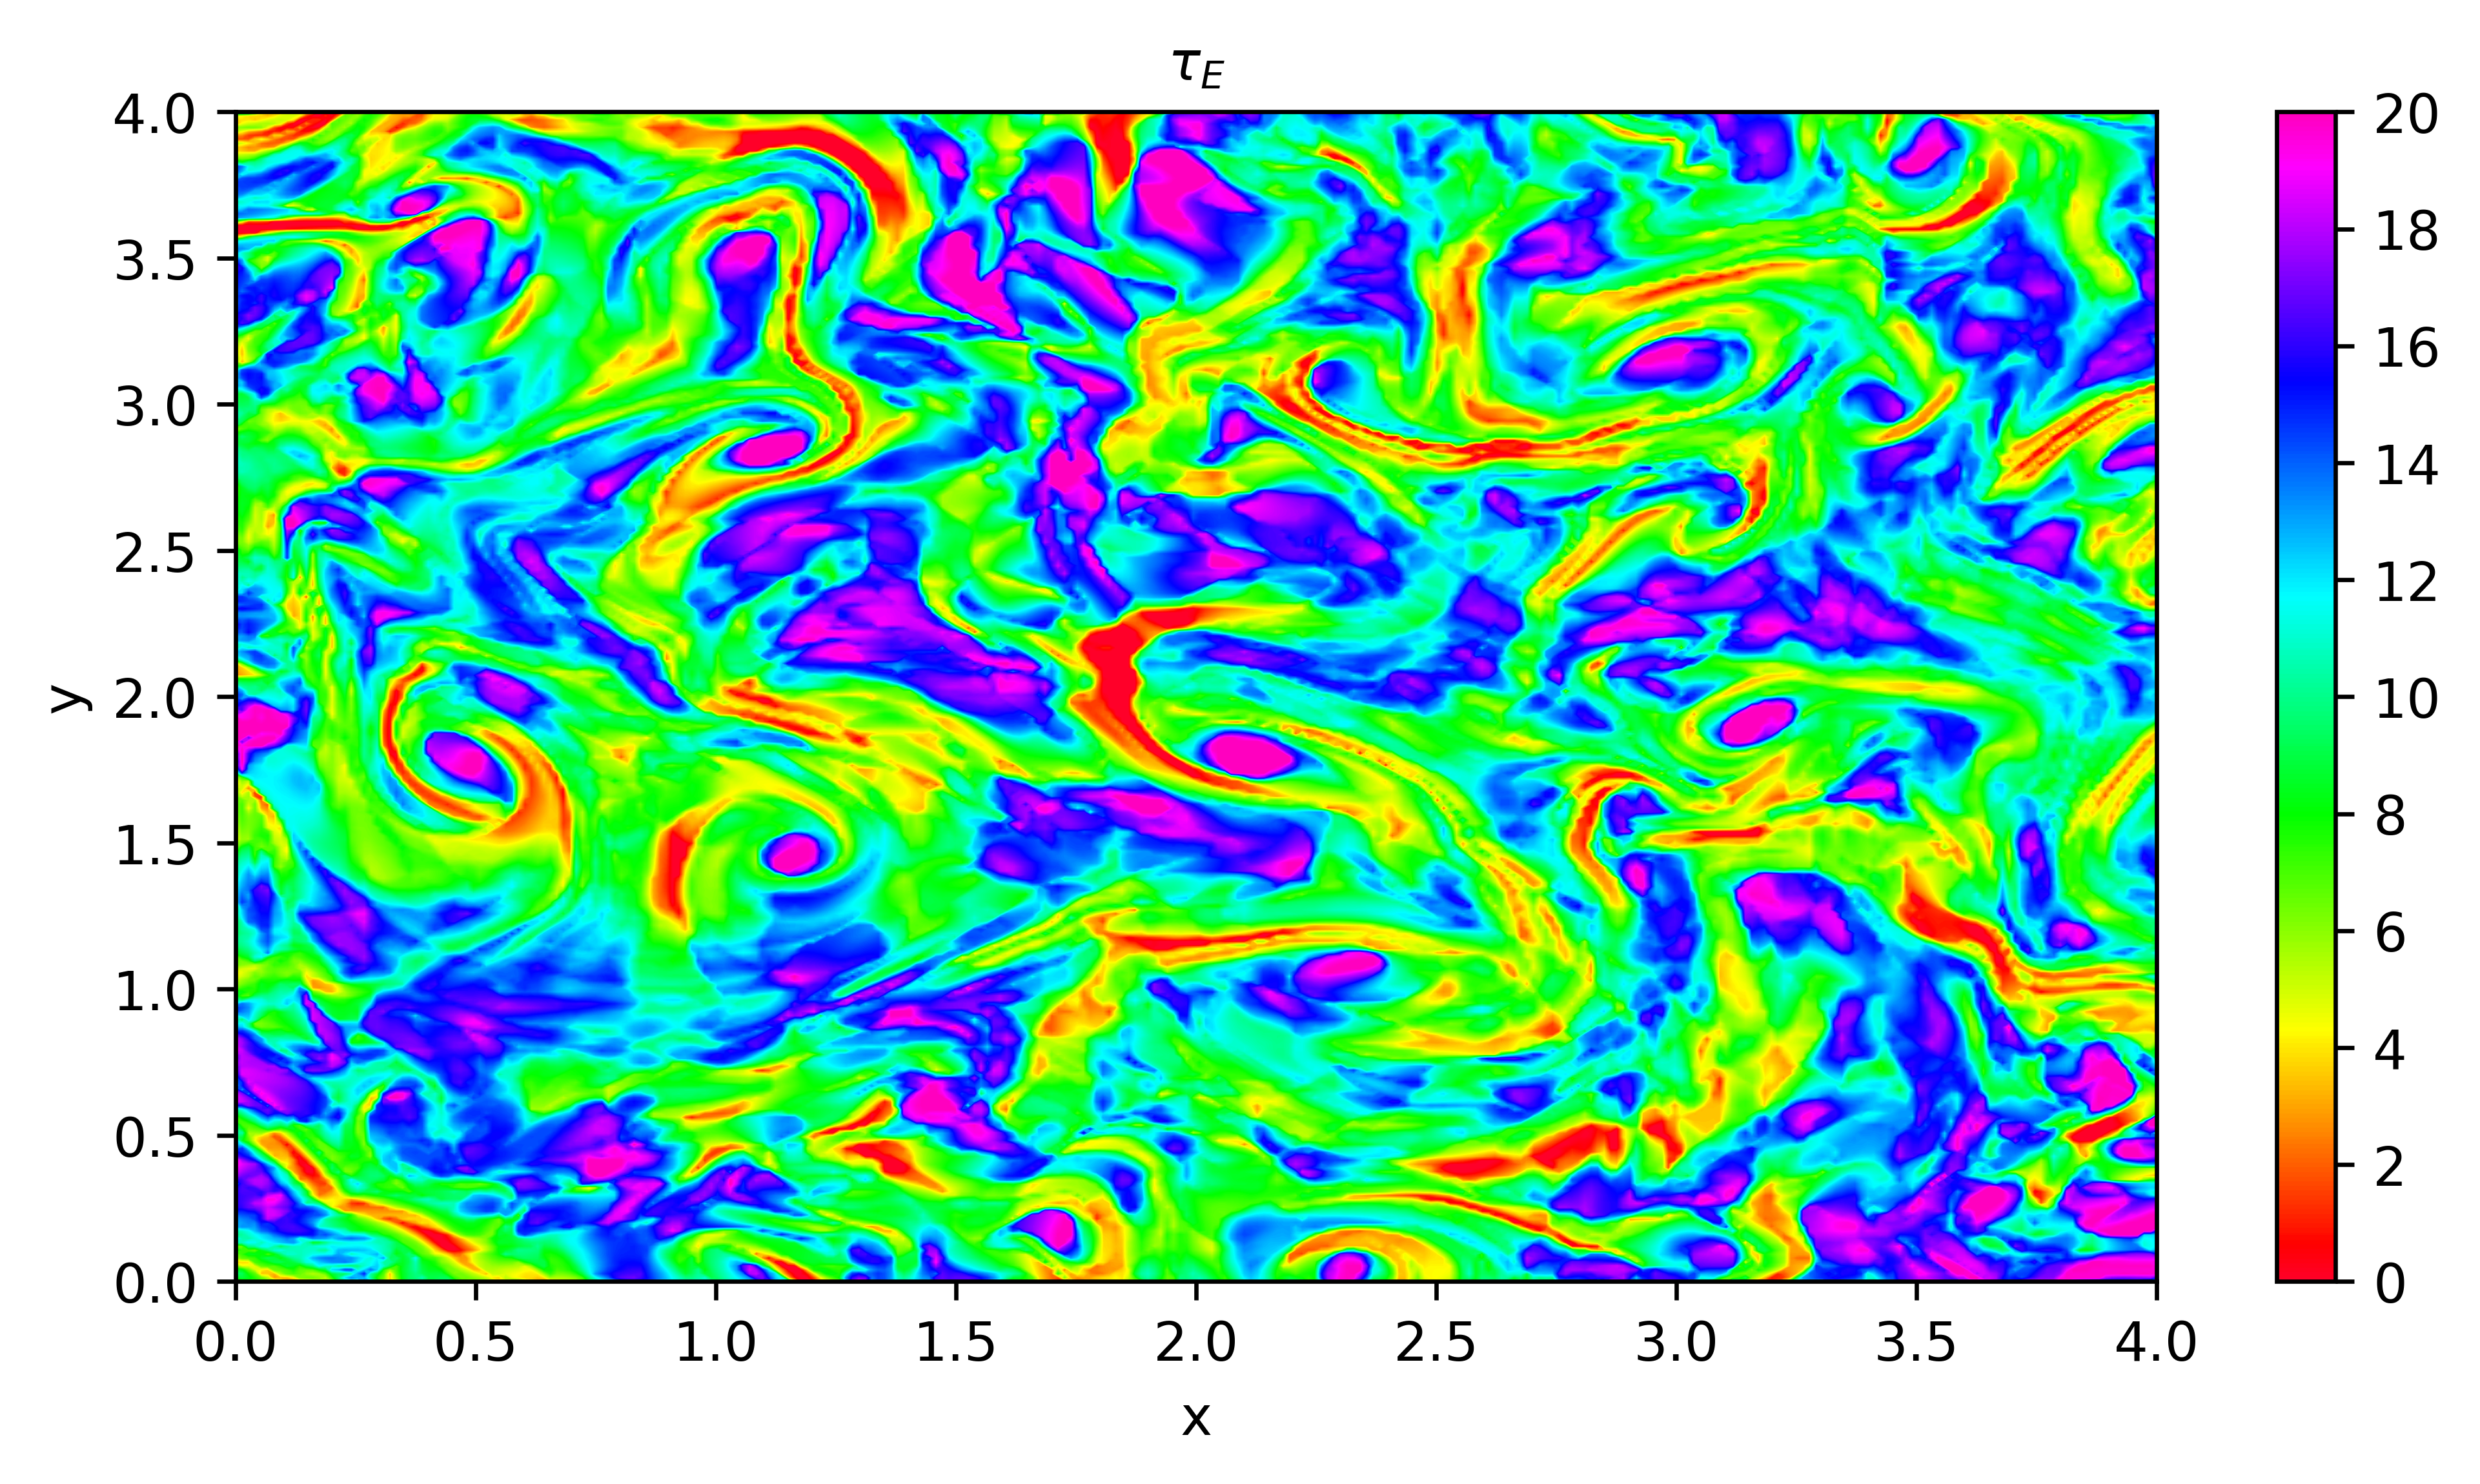

In [9]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of tau ellipticity over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(tau_Ellipticity), cmap = "gist_rainbow", levels = 600)

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 0.5))
ax.set_yticks(np.arange(ymin, ymax+0.1, 0.5))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, 20+.1, 2))

# Title
ax.set_title(r'$ \tau_E $', fontsize = 10)

plt.show()

# References

[1] Haller, G. (2001). Lagrangian structures and the rate of strain in a partition of two-dimensional turbulence. Physics of Fluids, 13(11), 3365-3385.

[2] Notebook 5.13. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.